In [3]:
##### base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os

# matplotlib
%matplotlib inline

# display
from IPython.display import display

# autoreload
%load_ext autoreload
%autoreload 2

# warnings
import warnings
warnings.filterwarnings('ignore')

# fix random seed
from numpy.random import seed as set_random_seed
set_random_seed(42)

# explainability
# import shap, lime #eli5
# shap.initjs()

# debug
# from icecream import ic
# debug = ic
import logging
logg = logging.info

In [4]:
import utils.utils as util
from utils.utils import Parms

# Params

In [37]:
ONLY_LUAD02 = True
SAMPLE = False
SAMPLE_FRAC = 0.05

TEST_FRAC = 0.2

In [38]:
# metric
from sklearn.metrics import f1_score, accuracy_score
from utils.metric_utils import HardMetric
final_metric = HardMetric(f1_score)

In [39]:
if ONLY_LUAD02:
    bam_dir = '../data/sample'
else:
    bam_dir = '../data/seqmerge/DLbams_rand'

In [40]:
# parser = argparse.ArgumentParser()
# params = {
#     'sample_split': True,
#     'model' : 'SimpleCnn',
#     'hidden_size' : 64,
#     'sequence_length' : 200,
#     'batch_size' : 512,
#     'learning_rate' : 0.00001,
#     'max_epoch' : 100,
#     'lstm_layers' : 10,
#     'dropout' : 0.5,
#     'out' : 'output',
#     'test' : 'Test directory',
#     'training_bam_dir' : bam_dir,
#     'sample_split' : True,
#     'model' : "metaSimpleDense",
#     'hidden_size' : 64,
#     'batch_size' : 32,
#     'learning_rate' : 0.001,
#     'max_epoch' : 20,
#     'dropout' : 0.005,
#     'num_workers' : 1
# }

# args = parser.parse_known_args()[0]
# args.__dict__.update(params)
# parms = Parms(
#     args
# )

# Data Loading

In [41]:
from modules.data_loading import DataLoader
raw_data = DataLoader.load_from_dir(bam_dir)

In [42]:
if SAMPLE:
    data = np.random.choice(raw_data, int(SAMPLE_FRAC * len(raw_data)))
else:
    data = raw_data
len(data)

5010

# Feature Extraction

## X Extraction

### Meta

In [43]:
X_meta = pd.DataFrame([read.meta for read in data])
X_meta

,tlen,query_length,tlen_normalized,is_reverse,is_read1,is_read2,mapping_quality,query_length_normalized,tag_NM,tag_AS,tag_XS,tag_MC
0,27,151,0.040,1,1,0,0.900,0.221,0.01,0.292,133,151.0
1,27,151,0.040,0,0,1,0.667,0.221,0.06,0.252,126,151.0
2,216,151,0.316,0,1,0,0.783,0.221,0.03,0.274,131,151.0
3,216,151,0.316,1,0,1,1.000,0.221,0.17,0.132,47,151.0
4,131,151,0.192,0,0,1,0.000,0.221,0.07,0.194,97,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5005,0,231,0.000,1,0,0,0.617,0.338,0.00,0.462,211,-1.0
5006,0,149,0.000,1,0,0,0.083,0.218,0.01,0.288,139,-1.0
5007,0,169,0.000,0,0,0,0.017,0.247,0.01,0.322,158,-1.0
5008,0,164,0.000,1,0,0,0.700,0.240,0.00,0.328,144,-1.0


### Seq

In [44]:
X_seq = None

In [215]:
SEQ_TAGS = ['A', 'C', 'G', 'T', -1]
CIGAR_TAGS = ["M","I","D","N","S","H","P","=","X", -1]

columns_to_drop = ['seq_-1', 'cigar_-1']

def extract_seq_by_tags(seq, tags, prefix = ''):
    df = pd.get_dummies(seq)
    for tag in (set(tags) - set(df.columns)):
            df[tag] = 0
    df = df[tags]
    df.columns = [prefix + str(tag) for tag in tags]
    return df

def extract_features_from_read(read, columns_to_drop = []):
    features = pd.concat([
        extract_seq_by_tags(read.seq, SEQ_TAGS, prefix = 'seq_'),
        extract_seq_by_tags(read.cigar, CIGAR_TAGS, prefix = 'cigar_'),
        pd.DataFrame({'qual': read.qual})       
    ], axis = 1)
    features = features.drop(columns = columns_to_drop)
    return features

X_seq = np.array([extract_features_from_read(r, columns_to_drop=columns_to_drop).values for r in data])

In [235]:
extract_features_from_read(data[0])

,seq_A,seq_C,seq_G,seq_T,seq_-1,cigar_M,cigar_I,cigar_D,cigar_N,cigar_S,cigar_H,cigar_P,cigar_=,cigar_X,cigar_-1,qual
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.323
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.290
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.312
3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.312
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-1.000
196,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-1.000
197,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-1.000
198,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-1.000


In [216]:
X_seq.shape

(250, 200, 14)

In [45]:
if X_seq is None:
    X_seq = X_meta

## y Extraction

In [46]:
y = pd.Series([read.label for read in data])
y.value_counts() / y.shape[0]

1    0.523154
0    0.476846
dtype: float64

## train-val-test split

In [47]:
from sklearn.model_selection import train_test_split
X_seq_train, X_seq_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(X_seq, X_meta, y, test_size = TEST_FRAC)
X_seq_train, X_seq_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(X_seq_train, X_meta_train, y_train, test_size = TEST_FRAC)
y_train.shape[0], y_val.shape[0], y_test.shape[0]

(3206, 802, 1002)

In [48]:
X_meta_val.shape

(802, 12)

# Model Selection

## Model choice

In [49]:
from models import *

### Meta

In [24]:
from models.torch import TorchModel
from modules.models import metaSimpleDense, nucSimpleCnn, nucCnnLinear
clf = TorchModel(metaSimpleDense(X_meta_train.shape[1]))

In [50]:
from models import XGBModel
clf_meta = XGBModel()

### Seq

### Ensemble

In [239]:
clf_ensemble = XGBModel()

## train Fitting

In [51]:
clf_meta.fit(X_meta_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [241]:
clf_seq.fit(X_meta_train, y_train, learning_rate=0.001, epochs=3)

NameError: name 'clf_seq' is not defined

### Val Fitting

In [53]:
clf_ensemble.fit(X_val, y_val)#, learning_rate=0.001, epochs=3)

NameError: name 'clf_ensemble' is not defined

## Predict

In [54]:
y_pred_meta = clf.predict_proba(X_meta_test)[:,1]

In [55]:
y_pred = y_pred_meta

# Evaluation

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
for th in np.arange(20)/20:
    print(f'''at {th} acc is {np.round(accuracy_score(y_test, (y_pred > th)),2)} prec is {np.round(precision_score(y_test, (y_pred > th)),2)} rec is {np.round(recall_score(y_test, (y_pred > th)),2)} f1_score is {np.round(f1_score(y_test, (y_pred > th)),2)}''')

at 0.0 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.05 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.1 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.15 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.2 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.25 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.3 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.35 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.4 acc is 0.52 prec is 0.52 rec is 1.0 f1_score is 0.68
at 0.45 acc is 0.52 prec is 0.54 rec is 0.48 f1_score is 0.51
at 0.5 acc is 0.49 prec is 0.75 rec is 0.01 f1_score is 0.01
at 0.55 acc is 0.48 prec is 0.0 rec is 0.0 f1_score is 0.0
at 0.6 acc is 0.48 prec is 0.0 rec is 0.0 f1_score is 0.0
at 0.65 acc is 0.48 prec is 0.0 rec is 0.0 f1_score is 0.0
at 0.7 acc is 0.48 prec is 0.0 rec is 0.0 f1_score is 0.0
at 0.75 acc is 0.48 prec is 0.0 rec is 0.0 f1_score is 0.0
at 0.8 acc is 0.48 prec is 0.0 rec is 0.

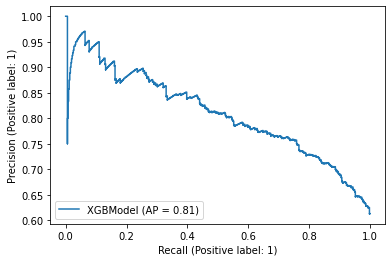

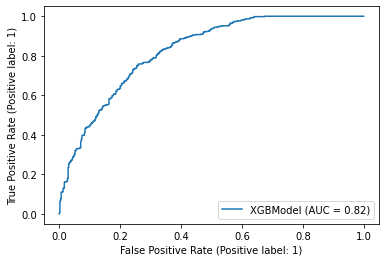

In [60]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
plot_precision_recall_curve(clf_meta, X_meta_test, y_test)
plot_roc_curve(clf_meta, X_meta_test, y_test)

In [58]:
final_metric(y_test, y_pred)

0.6816084377059987

# Playground

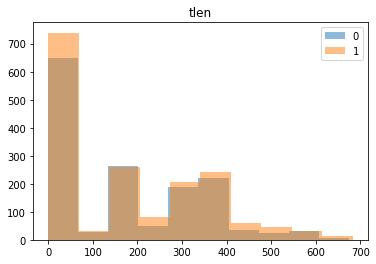

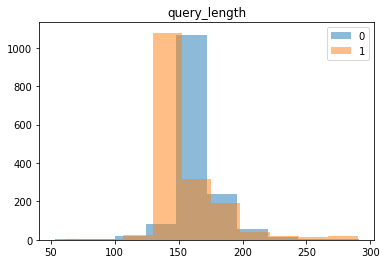

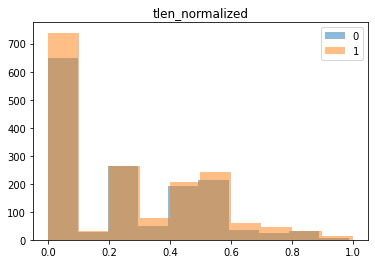

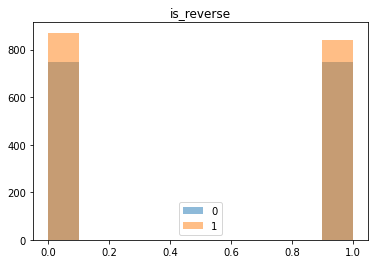

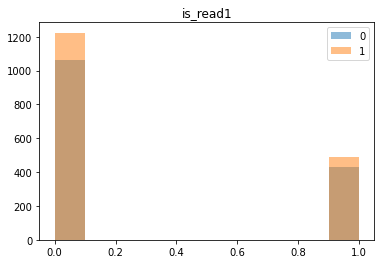

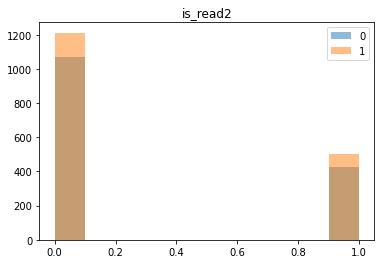

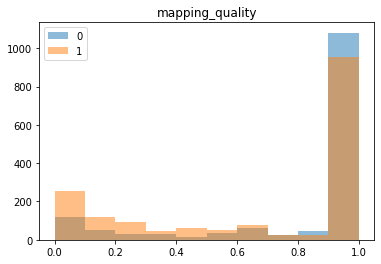

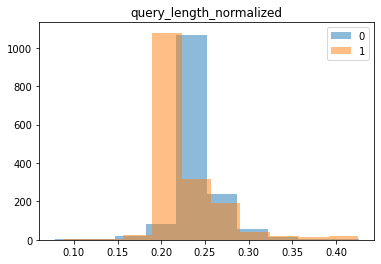

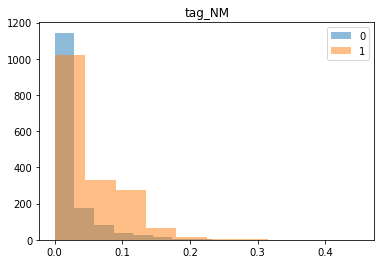

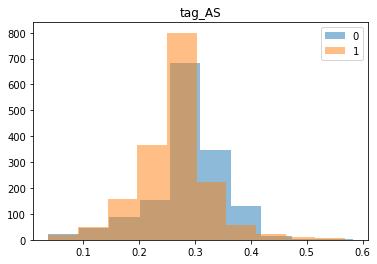

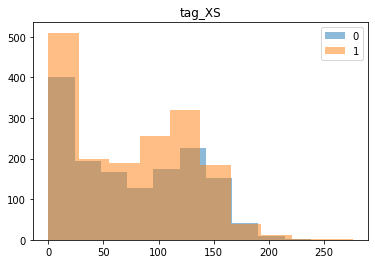

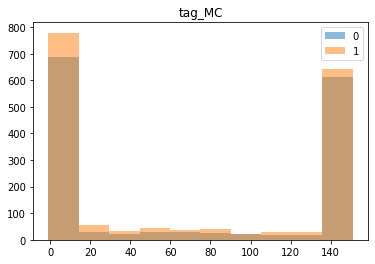

In [59]:
def print_feature(x,y):
    plt.title(x.name) 
    for label in [0,1]:
        plt.hist(x[y==label], alpha = 0.5, label = label)
    plt.legend()
    plt.show()

def save_feature_histogram(x,y, title):
    hist_0, bin_edges_0 = np.histogram(x[y==0])
    hist_1, bin_edges_1 = np.histogram(x[y==1])
    pd.DataFrame({
        'bins_healthy': bin_edges_0[1:],
        'hist_healthy': hist_0,
        'bins_somatic': bin_edges_1[1:],
        'hist_somatic': hist_1
    }
    ).to_excel(PLOTS_DIR / f"histogram__{title}.xlsx")
    
\
for col in X_meta_train.columns:
    print_feature(X_meta_train[col], y_train)